In [6]:
import numpy as np
from os import listdir
from os.path import isfile, join

In [20]:
mapping_set_to_dir = {
    'A': (0,'Z'),
    'B': (1,'O'),
    'C': (2,'N'),
    'D': (3,'F'),
    'E': (4,'S')
}

file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [25]:
file_lists[4]

['S008.txt',
 'S020.txt',
 'S034.txt',
 'S035.txt',
 'S021.txt',
 'S009.txt',
 'S037.txt',
 'S023.txt',
 'S022.txt',
 'S036.txt',
 'S032.txt',
 'S026.txt',
 'S027.txt',
 'S033.txt',
 'S025.txt',
 'S031.txt',
 'S019.txt',
 'S018.txt',
 'S030.txt',
 'S024.txt',
 'S043.txt',
 'S057.txt',
 'S080.txt',
 'S094.txt',
 'S095.txt',
 'S081.txt',
 'S056.txt',
 'S042.txt',
 'S068.txt',
 'S054.txt',
 'S040.txt',
 'S097.txt',
 'S083.txt',
 'S082.txt',
 'S096.txt',
 'S041.txt',
 'S055.txt',
 'S069.txt',
 'S051.txt',
 'S045.txt',
 'S079.txt',
 'S092.txt',
 'S086.txt',
 'S087.txt',
 'S093.txt',
 'S078.txt',
 'S044.txt',
 'S050.txt',
 'S046.txt',
 'S052.txt',
 'S085.txt',
 'S091.txt',
 'S090.txt',
 'S084.txt',
 'S053.txt',
 'S047.txt',
 'S062.txt',
 'S076.txt',
 'S089.txt',
 'S088.txt',
 'S077.txt',
 'S063.txt',
 'S049.txt',
 'S075.txt',
 'S061.txt',
 'S100.txt',
 'S060.txt',
 'S074.txt',
 'S048.txt',
 'S070.txt',
 'S064.txt',
 'S058.txt',
 'S059.txt',
 'S065.txt',
 'S071.txt',
 'S067.txt',
 'S073.txt',

In [50]:
raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        
        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [51]:
raw_dataset['E'].shape

(100, 4097)

In [52]:
import matplotlib.pyplot as plt

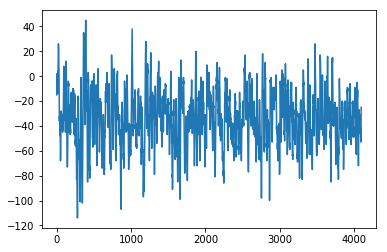

In [145]:
s = 'D'
index = 42
plt.plot(raw_dataset[s][index])

In [146]:
def create_augmented_dataset(window_size = 512, stride = 64):
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    return augmented_dataset


In [ ]:
aug_dataset512 = create_augmented_dataset()

In [147]:
aug_dataset1024 = create_augmented_dataset(window_size = 1024, stride = 128)

In [96]:
aug_dataset512['E'].shape

(5700, 512)

In [148]:
aug_dataset1024['E'].shape

(2500, 1024)

In [97]:
import h5py as h5

In [103]:
aug_file512 = h5.File('aug_dataset512.h5', 'w')

for s,Xset in aug_dataset512.items():
    aug_file512.create_dataset(s, data=Xset)

aug_file512.close()

In [149]:
aug_file1024 = h5.File('aug_dataset1024.h5', 'w')

for s,Xset in aug_dataset1024.items():
    aug_file1024.create_dataset(s, data=Xset)

aug_file1024.close()

In [150]:
aug_file512 = h5.File('aug_dataset512.h5', 'r')
aug_file512['A'].shape

(5700, 512)

In [151]:
aug_file1024 = h5.File('aug_dataset1024.h5', 'r')
aug_file1024['A'].shape

(2500, 1024)

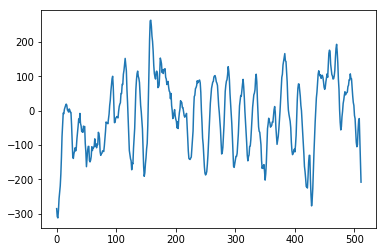

In [152]:
s = 'E'
index = 1140
plt.plot(aug_file512[s][index])

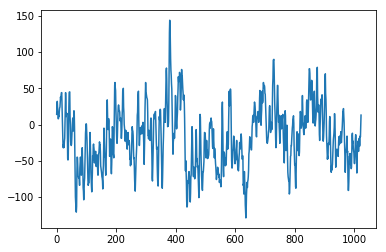

In [163]:
s = 'A'
index = 100
plt.plot(aug_file1024[s][index])